In [168]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk
import math

import os
import cProfile, pstats, io
#import memory_profiler
import psutil
import gc

# Enabling eager execution and set other configurations

In [169]:
tf.enable_eager_execution()
process = psutil.Process(os.getpid())

print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
#https://stackoverflow.com/questions/938733/total-memory-used-by-python-process

#https://pypi.org/project/memory-profiler/ - did not use it

UNK = '</s>'
FILLER = '</fill>'

MAX_BATCH_SIZE = 1024
MAX_WORD_COUNT = 40

# Load Google vectors

In [171]:
dirname = os.getcwd()
datasetPath = os.path.join(dirname, 'datasets/')
outfile = datasetPath +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
googleSet = pd.read_csv(datasetPath+'GoogleNews-vectors-negative10.txt', sep=' ', header=None)

print(googleSet.shape)
print(googleSet.head())

# TO BE DONE - Appropriate value should be added for FILLER (or) it has to be trained
fill_data = {0:FILLER}
for i in range(1, googleSet.shape[1]):
    fill_data[i] = i
googleSet = googleSet.append(fill_data, ignore_index=True)

print(googleSet.shape)
print(googleSet.head())

temp = list(googleCorpus)
temp.append(FILLER)
googleCorpus = set(temp)
corpus_length = len(google_corpus_word_to_int)
google_corpus_word_to_int[FILLER] = corpus_length
google_corpus_int_to_word[corpus_length] = FILLER


googleWords = googleSet.iloc[:,0:1]
googleVectors = googleSet.iloc[:,1:]

(1965717, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 -0.018799 -0.007111 -0.139648 -0.046631   
3     $  0.113770 -0.117676  0.064941  0.132812  0.054932 -0.099121  0.071289   
4   ###  0.149414 -0.191406  0.044189  0.104980  0.016846 -0.135742 -0.085449   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.077637  0.199219 -0.001770  
2 -0.063965  0.098145  0.135742  
3 -0.013306  0.271484 -0.083984  
4  0.074219  0.088867 -0.044922  
(1965718, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 

In [172]:
#UNK = '<unk>'

#glovePath = '/media/kandy/hdd/master-thesis/datasets/'
#outfile = glovePath +'glove_word_corpus.pic'

#with open(outfile, 'rb') as pickle_file:    
#    gloveCorpus, glove_corpus_word_to_int, glove_corpus_int_to_word = pickle.load(pickle_file)
#gloveSet = pd.read_csv(glovePath+'glove.42B.10d.txt', sep=' ', header=None)
#print(gloveSet.shape)
#print(gloveSet.head())

#gloveWords = gloveSet.iloc[:,0:1]
#gloveVectors = gloveSet.iloc[:,1:]

# Load training and test dataset

In [173]:
#treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-all-UNK.csv', sep=' ', header=None )
#treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-all-UNK-less-40-words.csv', sep=' ', header=None )
treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-40-UNK-NOLABEL.csv', sep=' ', header=None )

treeDataframe.columns =['sentence', 'tree']
treeDataframe['tree'] = treeDataframe['tree'].apply(nltk.Tree.fromstring)

treeDataframe.head()

,sentence,tree
0,pierre </s> </s> </s> years old </s> will join...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
1,mr. </s> is chairman of elsevier n.v. </s> the...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
2,rudolph agnew </s> </s> years old and former c...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
3,the asbestos fiber </s> </s> </s> is unusually...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
4,lorillard inc. </s> the unit of new </s> loews...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...


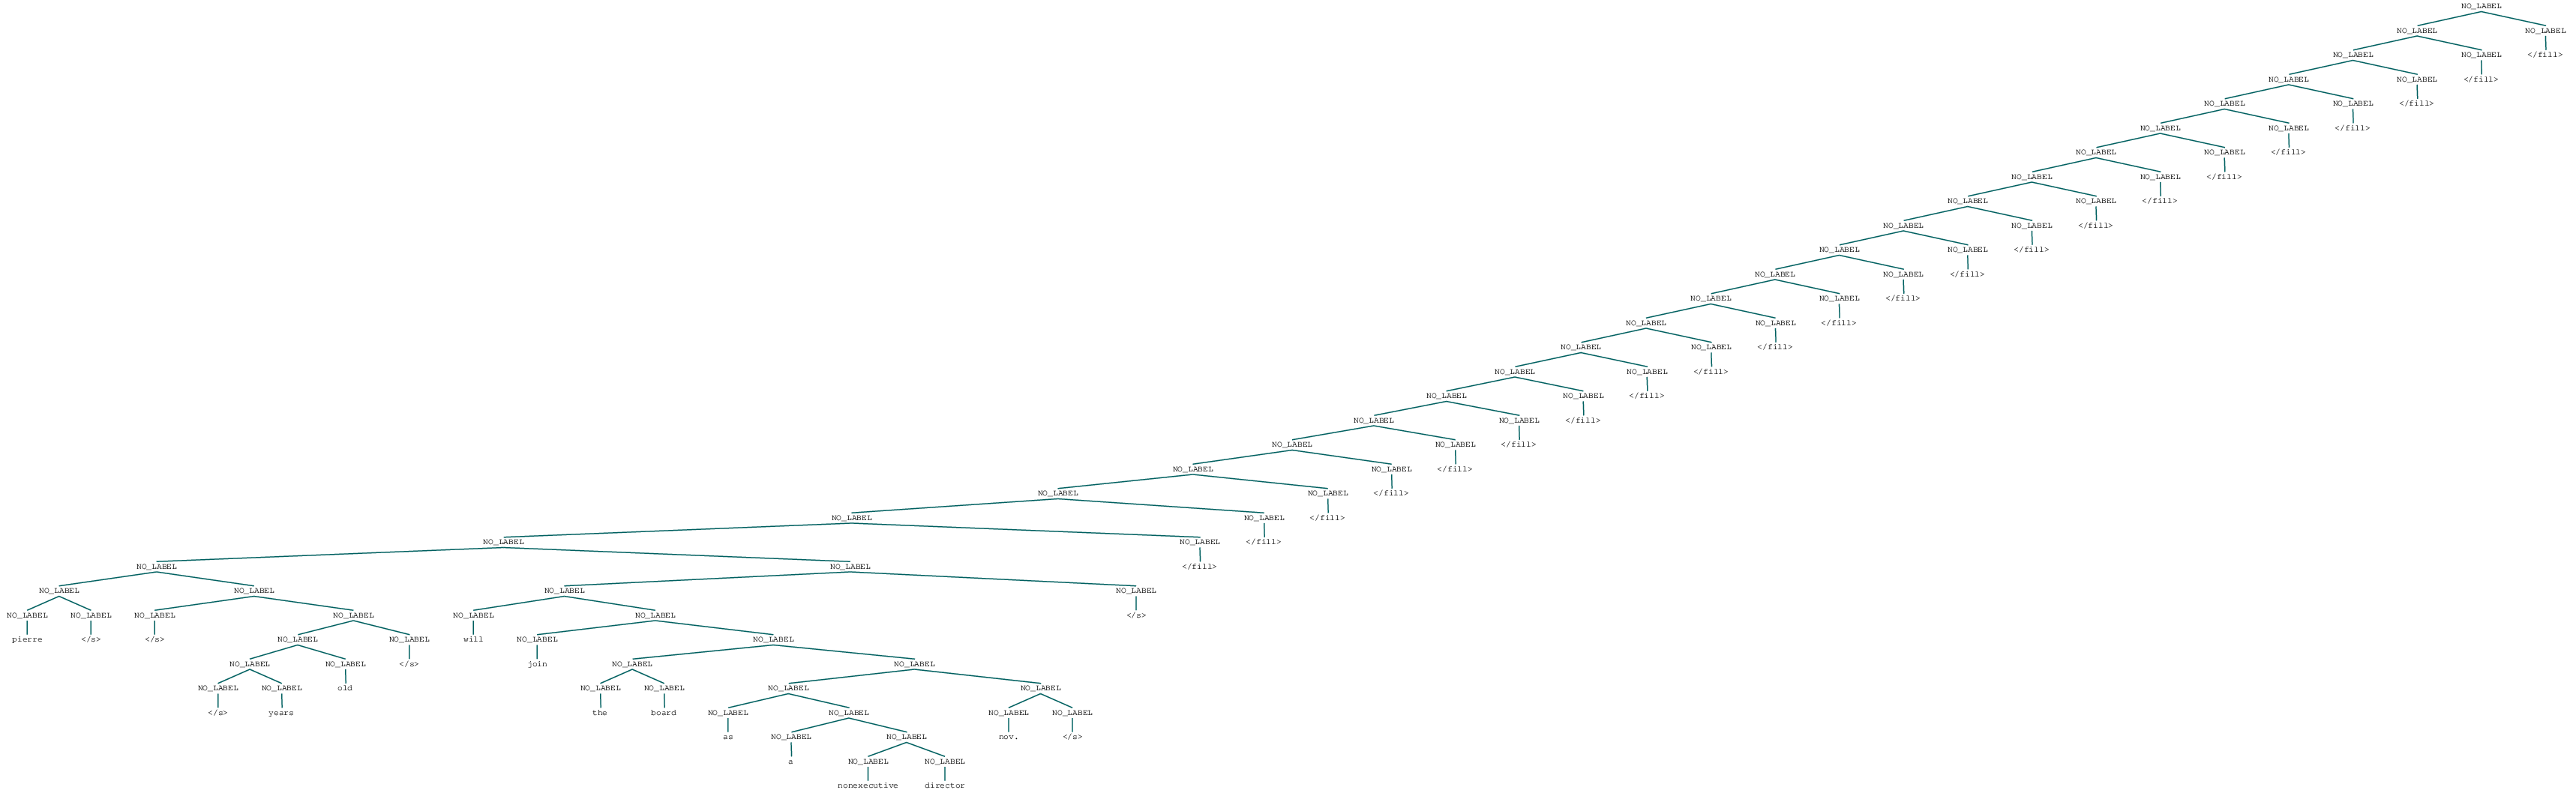

In [174]:
treeDataframe.iat[0,1]

In [175]:
def convert_imdb_corpus_into_int(sentence):
    words = sentence.split()
    words_to_num = [google_corpus_word_to_int[word] for word in words]
    return words_to_num

treeDataframe_num = treeDataframe.copy()
treeDataframe_num['sentence'] = treeDataframe_num['sentence'].apply(convert_imdb_corpus_into_int)
treeDataframe_num.head()

,sentence,tree
0,"[353287, 920150, 920150, 920150, 1131873, 1851...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
1,"[778656, 920150, 1025196, 261666, 920355, 5478...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
2,"[880384, 206120, 920150, 920150, 1131873, 1851...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
3,"[1323513, 151538, 1349057, 920150, 920150, 920...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
4,"[529848, 234617, 920150, 1323513, 1901239, 920...",[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...


In [176]:
#compute the tree formation index for the golden tree
# This does a depth first traversal of tree and gets the left child index of each sub-tree formation
def convert_tree(tree, leaves, input_list):
    if(type(tree[0]) == type('some string')):
        # we use the leaves() function to get the indexes of child elements
        # everytime when an element is found, it is important to remove them to avoid getting them reused
        leaveIndex = leaves.index(tree[0])
        leaves[leaveIndex]=''
        return leaveIndex
    
    leftIndex = convert_tree(tree[0], leaves, input_list)
    rightIndex = convert_tree(tree[1], leaves, input_list)
    input_list.append(leftIndex)
    return leftIndex

def convert_trees(tree):
    tree_combination= []
    tree_leaves = tree.leaves()
    convert_tree(tree, tree_leaves, tree_combination)
    
    # the indexes obtained for forming the tree assumes the size of the leaves is unchanged.
    # But everytime when a subtree is formed two nodes are merged together and hence size reduces
    
    # the below code is to make sure the index is updated as according to where the merge happened
    # all the indexes which are right to where the merge happened has to get subtracted by 1 
    # because of removal of a node
    
    for i in range(len(tree_combination)-1):
        for j in range(i+1, len(tree_combination)):
            if(tree_combination[j] > tree_combination[i]):
                tree_combination[j] = tree_combination[j] - 1
    return np.array(tree_combination)

columnList = []
for i in range(MAX_WORD_COUNT-1):
    columnList.append('c'+str(i))
#get the list of indexes and store it in column 'c'. Afterwards break the 'c' to MAX_WORD_COUNT-1 columns
treeDataframe_num['c'] = treeDataframe_num['tree'].apply(convert_trees)
treeDataframe_num[columnList] = pd.DataFrame(treeDataframe_num.c.values.tolist(), index= treeDataframe_num.index)
treeDataframe_num.drop(columns=['tree', 'c'], inplace=True)
treeDataframe_num.head()

,sentence,c0,c1,c2,c3,c4,c5,c6,c7,c8,...,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38
0,"[353287, 920150, 920150, 920150, 1131873, 1851...",0,2,2,2,1,0,3,6,5,...,0,0,0,0,0,0,0,0,0,0
1,"[778656, 920150, 1025196, 261666, 920355, 5478...",0,4,8,7,6,5,4,3,2,...,0,0,0,0,0,0,0,0,0,0
2,"[880384, 206120, 920150, 920150, 1131873, 1851...",0,2,2,4,8,7,6,5,4,...,0,0,0,0,0,0,0,0,0,0
3,"[1323513, 151538, 1349057, 920150, 920150, 920...",1,0,2,1,0,2,6,5,4,...,3,3,2,1,0,0,0,0,0,0
4,"[529848, 234617, 920150, 1323513, 1901239, 920...",0,2,4,5,4,3,7,6,5,...,0,0,0,0,0,0,0,0,0,0


In [177]:
treeDF_train, treeDF_test = sklearn.model_selection.train_test_split(treeDataframe_num, test_size=0.2)
print(treeDF_train.shape)
print(treeDF_test.shape)

(35067, 40)
(8767, 40)


In [178]:
#treeDF_train = treeDataframe_num.iloc[treeDataframe_num.shape[0]-50:treeDataframe_num.shape[0]]
#treeDF_test = treeDataframe_num.iloc[0:treeDataframe_num.shape[0]-50]
#print(treeDF_train.shape)
#print(treeDF_test.shape)

# Model and the Parameters

In [179]:
STATE_SIZE = 10
embeddings = tfe.Variable(name='embeddings', validate_shape= googleVectors.shape, 
                          initial_value=googleVectors.values, 
                          dtype=tf.float32, trainable=False)
w = tfe.Variable(name='w', validate_shape=(2*googleVectors.shape[1], STATE_SIZE), 
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(2*googleVectors.shape[1], STATE_SIZE)),
                 dtype=tf.float32)
b = tfe.Variable(name='b', validate_shape=(1, STATE_SIZE),
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(1, STATE_SIZE)),
                 dtype=tf.float32)

w_score = tfe.Variable(name='w_score', validate_shape=(STATE_SIZE, 1), 
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(STATE_SIZE, 1)),
                 dtype=tf.float32)
b_score = tfe.Variable(name='b_score', validate_shape=(1, 1),
                 initial_value=tf.contrib.layers.xavier_initializer()(shape=(1, 1)),
                 dtype=tf.float32)

#print(w)
#print(b)
#print(w_score)
#print(b_score)

In [180]:
print(embeddings.shape)
lookup = tf.nn.embedding_lookup(embeddings, google_corpus_word_to_int['</s>'])
lookup = tf.reshape(lookup, shape=(1, lookup.shape[0]))
print(lookup)

(1965718, 10)
tf.Tensor(
[[ 0.09570312 -0.03881836  0.05883789  0.03930664 -0.01300049 -0.1484375
   0.07568359 -0.13378906  0.2890625   0.00370789]], shape=(1, 10), dtype=float32)


In [181]:
def compare_trees(actual, predicted):
    actual_sub_trees = actual.subtrees()
    
    
    total_count = 0.0 #len(actual_sub_trees)
    match_count = 0.0
    
    for sub_tree in actual_sub_trees:
        #print('Sub Tree:', sub_tree)
        #print(predicted_sub_trees)
        predicted_sub_trees = predicted.subtrees()
        for temp_tree in predicted_sub_trees:
            #print(' ', temp_tree)
            if(sub_tree == temp_tree):
                match_count = match_count + 1.0
                break
        total_count = total_count + 1.0
        #break
    #print('Match:', match_count,' Total:', total_count)
    
    return [match_count/total_count, match_count, total_count]

#compare_trees(treeDF_train.iat[2,1], treeDF_train.iat[2,1])

t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
sub_trees = t1.subtrees()
for sub_tree in sub_trees:
    print(sub_tree)

(S (NP I) (VP (V saw) (NP him)))
(NP I)
(VP (V saw) (NP him))
(V saw)
(NP him)


In [182]:
def embedding_lookup(input_words):
    words = tf.nn.embedding_lookup(embeddings, input_words)
    return words

In [193]:
gc.collect()

pr = cProfile.Profile()
pr.enable()

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

start_memory = process.memory_info().rss
start_time = timer()


# calculate the upper limit for BATCH_COUNT
BATCH_COUNT = int(math.ceil(treeDF_train.shape[0]/MAX_BATCH_SIZE))
print('StartMemory (MB): ', start_memory/(1024*1024))
print('Epoch Batch Loss Time(sec) Memory(MB)')

for epoch in range(300) :
     
    for batch_no in range(BATCH_COUNT):

        #print('Epoch:', epoch,'Batch:', batch_no,'/',BATCH_COUNT)
        
        # Recorded only batch-wise. that is enough to calculate gradients and apply them
        with tf.GradientTape() as tape:
            
            # Extract the appropriate batch data. For the last batch, the size of the data can be lesser
            start = batch_no * MAX_BATCH_SIZE
            stop = start + MAX_BATCH_SIZE
            mini_batch_data = treeDF_train.iloc[start:stop]
            BATCH_SIZE = mini_batch_data.shape[0]
            
            # get the word vectors - its shape will be (no. of sentence, no.of words, no. of states)
            data = embedding_lookup(mini_batch_data['sentence'])
            gold_data = embedding_lookup(mini_batch_data['sentence'])
            #data = tf.slice(embedding_lookup_out, [0,0,0], [BATCH_SIZE,MAX_WORD_COUNT,STATE_SIZE])
            #print(data.shape)
            
            NO_OF_SENTENCE = data.shape[0] # which is same as BATCH_SIZE
            NO_OF_WORDS = data.shape[1]

            total_predict_score = tf.zeros((BATCH_SIZE,1))
            total_actual_score = tf.zeros((BATCH_SIZE,1))
            
            # enumerate through all the word combinations
            # find the best combination, replace with respective two words
            # do it untill only one word is present
            for word_counter in range(NO_OF_WORDS-1):

                # concatenate the word combinations - first data will contain 1st to n-1th word and 
                # second data will contain 2nd to nth word
                first_data = tf.slice(data, [0,0,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                second_data = tf.slice(data, [0,1,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                concatenated_data = tf.concat([first_data, second_data], axis=2)

                # applying linear and non-linear transformation to output STATE_SIZE dimensions
                # this becomes the representation vector for phrases
                reshaped_data = tf.reshape(concatenated_data, (-1,2*STATE_SIZE))
                output_data = tf.tanh(tf.matmul(reshaped_data, w) + b)
                reshaped_output_data = tf.reshape(output_data, (NO_OF_SENTENCE,-1,STATE_SIZE))
                
                # compute score of the above transformation to rank them
                scored_data = tf.matmul(output_data, w_score) + b_score
                reshaped_scored_data = tf.reshape(scored_data, (NO_OF_SENTENCE,-1,1))
                
                max_scored_data = tf.reduce_max(reshaped_scored_data, axis=1)
                squeezed_max_score = tf.squeeze(max_scored_data)
                total_predict_score = tf.add(total_predict_score, squeezed_max_score)
                
                # get the list of indexes whose scores are high
                argmax_score = tf.argmax(reshaped_scored_data, axis=1, output_type=tf.int32)
                squeeze_argmax_score = tf.squeeze(argmax_score)
                # convert the indexing to support reshaping of 2D matrix. this is important to
                # remove the word vector at argmax position
                range_data = (tf.range(0, NO_OF_SENTENCE) * NO_OF_WORDS)
                range_data = tf.reshape(range_data, (NO_OF_SENTENCE,1))
                range_data = range_data + argmax_score
                # convert the indexes to support reshaping of 2D matrix with a word 
                # removed for every sentence. This is important because having got the word removed
                # this will help replace the phrase vector at argmax position for sentences with n-1 words
                range_data_minus = (tf.range(0, NO_OF_SENTENCE) * (NO_OF_WORDS-1))
                range_data_minus = tf.reshape(range_data_minus, (NO_OF_SENTENCE,1))
                range_data_minus = range_data_minus + argmax_score

                # create a bool list with true values of size sentences*words
                # replace the values at argmax position with false
                reshaped_data = tf.reshape(data, (-1,STATE_SIZE))
                range_data_list = tf.squeeze(range_data).numpy().tolist()
                bool_mask_data = [True] * (NO_OF_SENTENCE*NO_OF_WORDS)
                for i in range_data_list:
                    bool_mask_data[i] = False
                # use the boolean mask to filter the rows (axis=0)
                reshaped_new_data = tf.boolean_mask(reshaped_data, bool_mask_data, axis=0)
                
                # create a bool list with true values of size sentences*(words-1)
                # replace the values at argmax position with false
                range_data_minus_list = tf.squeeze(range_data_minus).numpy().tolist()
                bool_mask_data = [True] * (NO_OF_SENTENCE*(NO_OF_WORDS-1))
                for i in range_data_minus_list:
                    bool_mask_data[i] = False
                # replace the input words with phrase vectors at argmax position(bool mask data)
                data = tf.where(bool_mask_data, reshaped_new_data, output_data)
                data = tf.reshape(data,shape=(NO_OF_SENTENCE, -1, STATE_SIZE))
                
                # REPEAT THE SAME PROCESS (with minor changes) FOR GOLDEN TREE SCORE COMPUTATION
                first_gold_data = tf.slice(gold_data, [0,0,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                second_gold_data = tf.slice(gold_data, [0,1,0], [NO_OF_SENTENCE, NO_OF_WORDS-1, STATE_SIZE])
                concatenated_gold_data = tf.concat([first_gold_data, second_gold_data], axis=2)
                reshaped_gold_data = tf.reshape(concatenated_gold_data, (-1,2*STATE_SIZE))
                output_gold_data = tf.tanh(tf.matmul(reshaped_gold_data, w) + b)
                reshaped_output_gold_data = tf.reshape(output_gold_data, (NO_OF_SENTENCE,-1,STATE_SIZE))
                
                scored_gold_data = tf.matmul(output_gold_data, w_score) + b_score
                reshaped_scored_gold_data = tf.reshape(scored_gold_data, (NO_OF_SENTENCE,-1,1))
                
                #get the argmax score which is stored in mini_batch_data
                argmax_gold_score = tf.convert_to_tensor(mini_batch_data['c'+str(word_counter)], dtype=tf.int32)
                argmax_gold_score = tf.reshape(argmax_gold_score, shape=(argmax_gold_score.shape[0], 1))
                squeeze_argmax_gold_score = tf.squeeze(argmax_gold_score)
                
                range_gold_data = (tf.range(0, NO_OF_SENTENCE) * NO_OF_WORDS)
                range_gold_data = tf.reshape(range_gold_data, (NO_OF_SENTENCE,1))
                range_gold_data = range_gold_data + argmax_gold_score
                
                #the score of intended combination is chosen and added up
                max_scored_gold_data = tf.gather(scored_gold_data, range_gold_data)
                squeezed_max_gold_score = tf.squeeze(max_scored_gold_data)
                total_actual_score = tf.add(total_actual_score, squeezed_max_gold_score)
                
                range_gold_data_minus = (tf.range(0, NO_OF_SENTENCE) * (NO_OF_WORDS-1))
                range_gold_data_minus = tf.reshape(range_gold_data_minus, (NO_OF_SENTENCE,1))
                range_gold_data_minus = range_gold_data_minus + argmax_gold_score
                
                reshaped_gold_data = tf.reshape(gold_data, (-1,STATE_SIZE))
                range_gold_data_list = tf.squeeze(range_gold_data).numpy().tolist()
                bool_gold_mask_data = [True] * (NO_OF_SENTENCE*NO_OF_WORDS)
                for i in range_gold_data_list:
                    bool_gold_mask_data[i] = False
                    
                reshaped_new_gold_data = tf.boolean_mask(reshaped_gold_data, bool_gold_mask_data, axis=0)
                
                range_gold_data_minus_list = tf.squeeze(range_gold_data_minus).numpy().tolist()
                bool_gold_mask_data1 = [True] * (NO_OF_SENTENCE*(NO_OF_WORDS-1))
                for i in range_gold_data_minus_list:
                    bool_gold_mask_data1[i] = False

                gold_data = tf.where(bool_gold_mask_data1, reshaped_new_gold_data, output_gold_data)
                gold_data = tf.reshape(gold_data,shape=(NO_OF_SENTENCE, -1, STATE_SIZE))
                
                NO_OF_SENTENCE = data.shape[0]
                NO_OF_WORDS = data.shape[1]
                
            #get the scores and compute the loss
            final_predict_score = tf.squeeze(reshaped_scored_data)
            total_predict_score = tf.add(total_predict_score, final_predict_score)
            final_actual_score = tf.squeeze(reshaped_scored_gold_data)
            total_actual_score = tf.add(total_actual_score, final_actual_score)
            
            losses = tf.abs(total_predict_score - total_actual_score)
            avg_loss = tf.reduce_mean(losses)
            
            # use the gradient tape to update the parameter values
            grads = tape.gradient(avg_loss, [w,b,w_score,b_score])
            grad_op = optimizer.apply_gradients(zip(grads, [w,b,w_score,b_score]), 
                                      global_step=tf.train.get_or_create_global_step())
            #print(avg_loss)
            
            stop_memory = process.memory_info().rss
            stop_time = timer()
            print(epoch, batch_no, avg_loss.numpy(), (stop_time - start_time), ((stop_memory - start_memory) /(1024*1024)))
            #gc.collect()

    if(epoch %10 == 0):
        parameters = [w, b, w_score, b_score]
        with open('parameters'+str(timer())+'.pic', 'wb') as pickle_file:    
            pickle.dump(parameters, pickle_file)

pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
#print(s.getvalue())

StartMemory (MB):  7228.375
Epoch Batch Loss Time(sec) Memory(MB)
0 0 0.44453046 3.0853707309943275 0.0
0 1 11.356846 6.178533563994279 0.0
0 2 0.44594118 9.283349773999362 0.0
0 3 11.380563 12.383170001994586 0.0
0 4 0.4595869 15.455068961993675 0.0
0 5 11.3684025 18.536706317994685 0.0
0 6 0.4397358 21.594247369997902 0.0
0 7 11.36572 24.68954159200075 0.0
0 8 0.463841 27.746884242995293 0.0
0 9 11.382779 30.847321346998797 0.0
0 10 0.46278456 33.93018266799481 0.0
0 11 11.349845 37.000571040996874 0.0
0 12 0.48518938 40.05563630499819 0.0
0 13 11.3523855 43.15361064399622 0.0
0 14 0.4587942 46.27196767999703 0.0
0 15 11.370353 49.337427260994446 0.0
0 16 0.4465046 52.41852825800015 0.0
0 17 11.353667 55.60320988899912 0.0
0 18 0.46386123 58.765102347999346 0.0
0 19 11.354408 61.95001339199371 0.0
0 20 0.45320004 65.21770648299571 0.0
0 21 11.37405 68.39264183100022 0.0
0 22 0.4441252 71.6875336669982 0.0
0 23 11.369006 74.75701696099713 0.0
0 24 0.44061735 77.91644536999956 0.0
0 25

5 33 0.5152607 647.5656158740021 0.25
5 34 11.118422 648.6583170450031 0.25
6 0 0.34550402 651.8542920740001 0.25
6 1 11.447962 655.0321652690036 0.25
6 2 0.34509286 658.124092965998 0.25
6 3 11.464337 661.2835726839985 -0.50390625
6 4 0.35812178 664.3648231690022 -0.50390625
6 5 11.458919 667.4085827719973 -0.50390625
6 6 0.33821562 670.5566931950016 -0.50390625
6 7 11.461881 673.6073127139971 -0.50390625
6 8 0.36045906 676.6748212349921 -0.50390625
6 9 11.467301 679.7586255459901 -0.50390625
6 10 0.36575127 682.8356254949904 -0.50390625
6 11 11.455962 685.9196246929932 -0.50390625
6 12 0.3694393 689.0041223389999 -0.50390625
6 13 11.44583 692.064620324003 -0.46484375
6 14 0.35729522 695.1334589039907 -0.46484375
6 15 11.4614525 698.2184774509951 -0.46484375
6 16 0.35012296 701.3117540239909 -0.46484375
6 17 11.433756 704.3802004619938 -0.46484375
6 18 0.3717845 707.464724970996 -0.46484375
6 19 11.4307 710.5335253989906 -0.46484375
6 20 0.36720753 713.5967698500026 -0.46484375
6 21 1

11 7 0.43107247 1201.4390474389947 -0.4453125
11 8 11.367039 1204.5240254450036 -0.4453125
11 9 0.4225406 1207.628296844996 -0.4453125
11 10 11.395934 1210.7153994800028 -0.4453125
11 11 0.39970827 1213.8166144879942 -0.32421875
11 12 11.415933 1216.8926144739962 -0.32421875
11 13 0.38820547 1219.9780238059902 -0.32421875
11 14 11.4248905 1223.0519639569975 -0.32421875
11 15 0.39682356 1226.106677142001 -0.32421875
11 16 11.398502 1229.185455436993 -0.32421875
11 17 0.40031266 1232.2654214469949 -0.32421875
11 18 11.411012 1235.3454287829954 -0.3203125
11 19 0.3786427 1238.4031126839982 -0.3203125
11 20 11.239577 1241.4611204749963 -0.3203125
11 21 0.5752461 1244.6093381770042 -0.3203125
11 22 11.277528 1247.6893980809982 -0.3203125
11 23 0.5204605 1250.774551451992 -0.3203125
11 24 11.298747 1253.8439940719982 -0.3203125
11 25 0.53034586 1256.9014214179915 -0.3203125
11 26 11.2965145 1259.9664444329974 -0.3203125
11 27 0.52079684 1263.020932391999 -0.3203125
11 28 11.290816 1266.07631

16 11 11.477998 1741.7463785720029 -0.23046875
16 12 0.33524325 1744.8306311170018 -0.23046875
16 13 11.47084 1747.895843716993 -0.23046875
16 14 0.32223675 1750.9701767669903 -0.23046875
16 15 11.484721 1754.0456412259955 -0.23046875
16 16 0.31976858 1757.117407740996 -0.23046875
16 17 11.452655 1760.1936053270038 -0.23046875
16 18 0.3423188 1763.2771082809923 -0.23046875
16 19 11.449427 1766.342078718997 -0.23046875
16 20 0.33667898 1769.4194862330041 -0.23046875
16 21 11.472594 1772.4994147510006 -0.23046875
16 22 0.32231697 1775.5674758319947 -0.23046875
16 23 11.467944 1778.6310799509956 -0.23046875
16 24 0.32386056 1781.666486244998 -0.23046875
16 25 11.478576 1784.7209511109977 -0.23046875
16 26 0.33876607 1787.7748779899994 -0.23046875
16 27 11.467914 1790.8081460889953 -0.23046875
16 28 0.30871686 1793.8790464210033 -0.23046875
16 29 11.486951 1796.9745412789925 -0.23046875
16 30 0.32286867 1800.0317003529926 -0.23046875
16 31 11.493586 1803.1070670939953 -0.23046875
16 32 0.3

21 17 0.39543274 2289.6359155489918 -0.23046875
21 18 11.402867 2292.710534383994 -0.23046875
21 19 0.37682134 2295.7722059490043 -0.23046875
21 20 11.430929 2298.8478857579903 -0.23046875
21 21 0.37204373 2301.8932608640025 -0.23046875
21 22 11.440951 2304.9639427340007 -0.23046875
21 23 0.35241845 2308.027893391991 -0.23046875
21 24 11.426493 2311.0971103570046 -0.23046875
21 25 0.39039993 2314.1407566510024 -0.23046875
21 26 11.424896 2317.21372775099 -0.23046875
21 27 0.38443282 2320.2866489470034 -0.23046875
21 28 11.412902 2323.3528794360027 -0.23046875
21 29 0.39655757 2326.425311479994 -0.23046875
21 30 11.335331 2329.4572083910025 -0.23046875
21 31 0.4548495 2332.5062547019916 -0.23046875
21 32 11.377074 2335.5906748839916 -0.23046875
21 33 0.42063835 2338.6647792379954 -0.23046875
21 34 11.196464 2339.7535001420038 -0.23046875
22 0 0.24226074 2342.8002334539924 -0.23046875
22 1 11.5421715 2345.8377668039902 -0.23046875
22 2 0.24045885 2348.925251676992 -0.23046875
22 3 11.538

26 19 11.472381 2824.0699670589966 -0.23046875
26 20 0.30787662 2827.1573866800027 -0.23046875
26 21 11.495107 2830.222746265994 -0.23046875
26 22 0.29447868 2833.305758225004 -0.23046875
26 23 11.4904785 2836.3691572919925 -0.23046875
26 24 0.29211068 2839.4476987389935 -0.23046875
26 25 11.500931 2842.527604378003 -0.23046875
26 26 0.30731085 2845.6131225989957 -0.23046875
26 27 11.488677 2848.7147859499964 -0.23046875
26 28 0.2810116 2851.792686738001 -0.23046875
26 29 11.508688 2854.881253087995 -0.23046875
26 30 0.29328915 2857.967275982999 -0.23046875
26 31 11.512481 2861.0555407649954 -0.23046875
26 32 0.28162545 2864.1254756650014 -0.23046875
26 33 11.514889 2867.2013480809983 -0.23046875
26 34 0.26011023 2868.299692832996 -0.23046875
27 0 11.311475 2871.3501400329988 -0.23046875
27 1 0.45018393 2874.4318609549955 -0.23046875
27 2 11.369433 2877.5061425070016 -0.23046875
27 3 0.40664247 2880.5818670159933 -0.23046875
27 4 11.415075 2883.666499871004 -0.23046875
27 5 0.39271593 

31 20 11.347733 3355.1388962929923 -0.37109375
31 21 0.44982263 3358.1990977739915 -0.37109375
31 22 11.373024 3361.2637518199917 -0.37109375
31 23 0.4163623 3364.315026598997 -0.37109375
31 24 11.397721 3367.3490276240045 -0.37109375
31 25 0.41053295 3370.408004037992 -0.37109375
31 26 11.408368 3373.484062648 -0.37109375
31 27 0.3934149 3376.540963937994 -0.37109375
31 28 11.39305 3379.5806402759918 -0.37109375
31 29 0.40733337 3382.660982065994 -0.37109375
31 30 11.328598 3385.70313715699 -0.37109375
31 31 0.455446 3388.753806694993 -0.37109375
31 32 11.362058 3391.8439728079975 -0.37109375
31 33 0.42928383 3394.938050044002 -0.37109375
31 34 11.193103 3396.0264171610033 -0.37109375
32 0 0.23669864 3399.1065024790005 -0.37109375
32 1 11.54818 3402.1961015599954 -0.37109375
32 2 0.22942181 3405.2733287500014 -0.37109375
32 3 11.543518 3408.322633935997 -0.37109375
32 4 0.2506506 3411.4011295179953 -0.37109375
32 5 11.543533 3414.463882789001 -0.37109375
32 6 0.2334485 3417.5681680900

36 22 0.27012563 3888.8173008909944 -0.37109375
36 23 11.509949 3891.9017447310034 -0.37109375
36 24 0.26581395 3894.9733727709972 -0.37109375
36 25 11.520913 3898.077292472997 -0.37109375
36 26 0.27933732 3901.141028084996 -0.37109375
36 27 11.51037 3904.2178765169956 -0.37109375
36 28 0.25425935 3907.292490715001 -0.37109375
36 29 11.530685 3910.3576725320017 -0.37109375
36 30 0.26445115 3913.4492338159907 -0.37109375
36 31 11.534101 3916.5283430779964 -0.37109375
36 32 0.25716093 3919.631999007004 -0.37109375
36 33 11.532853 3922.705185054001 -0.37109375
36 34 0.23814327 3923.79625413999 -0.37109375
37 0 11.32788 3926.8347007289995 -0.37109375
37 1 0.42627147 3929.8837903950043 -0.37109375
37 2 11.381471 3932.952044363992 -0.37109375
37 3 0.38720018 3936.0116915260005 -0.37109375
37 4 11.428571 3939.061281408998 -0.37109375
37 5 0.37147966 3942.1379534610023 -0.37109375
37 6 11.416102 3945.1955624980037 -0.37109375
37 7 0.36904737 3948.2282329070003 -0.37109375
37 8 11.404392 3951.3

41 26 11.407661 4428.950451092998 -0.21875
41 27 0.3914371 4432.033731346994 -0.21875
41 28 11.401222 4435.108165020996 -0.21875
41 29 0.39196154 4438.190007359997 -0.21875
41 30 11.327695 4441.2635389959905 -0.21875
41 31 0.45065683 4444.320483613003 -0.21875
41 32 11.360303 4449.047678151997 -0.21875
41 33 0.42541572 4452.131626988994 -0.21875
41 34 11.190171 4453.224594993997 -0.21875
42 0 0.23230852 4456.274039204 -0.21875
42 1 11.549865 4459.308992453996 -0.21875
42 2 0.22259423 4462.366058058004 -0.21875
42 3 11.547327 4465.441059628996 -0.21875
42 4 0.24233745 4468.513429188999 -0.21875
42 5 11.546187 4471.601189936991 -0.21875
42 6 0.22661276 4474.681146631992 -0.21875
42 7 11.550405 4477.736268437991 -0.21875
42 8 0.24158348 4480.776939003001 -0.21875
42 9 11.553285 4483.844356499991 -0.21875
42 10 0.24451712 4486.900484882004 -0.21875
42 11 11.548893 4489.983729970991 -0.21875
42 12 0.24784614 4493.064901078993 -0.21875
42 13 11.542405 4496.136578955004 -0.21875
42 14 0.23432

47 7 0.28722465 5005.593776715992 -0.21875
47 8 11.491692 5008.673814606998 -0.21875
47 9 0.27483046 5011.7537001460005 -0.21875
47 10 11.525852 5014.8530876239965 -0.21875
47 11 0.24443221 5017.934593608996 -0.21875
47 12 11.542317 5021.036259151995 -0.21875
47 13 0.24388316 5024.095225167999 -0.21875
47 14 11.540774 5027.1596006280015 -0.21875
47 15 0.25590456 5030.230164189998 -0.21875
47 16 11.512338 5033.2966005920025 -0.21875
47 17 0.25567868 5036.3961458429985 -0.21875
47 18 11.532947 5039.494747894001 -0.21875
47 19 0.23160268 5042.596244234999 -0.21875
47 20 11.560815 5045.692873413995 -0.21875
47 21 0.22755136 5048.779280428003 -0.21875
47 22 11.548493 5051.867934144 -0.21875
47 23 0.23310064 5054.964265314004 -0.21875
47 24 11.550461 5058.027626219002 -0.21875
47 25 0.24735565 5061.104551411001 -0.21875
47 26 11.555777 5064.213413983001 -0.21875
47 27 0.24105133 5067.287704671995 -0.21875
47 28 11.53781 5070.359465089001 -0.21875
47 29 0.25402474 5073.458652289002 -0.21875
4

52 23 11.600062 5583.674309091002 -0.21875
52 24 0.16997662 5586.752352568001 -0.21875
52 25 11.608835 5589.855740173996 -0.21875
52 26 0.1815546 5592.925676451996 -0.21875
52 27 11.600555 5595.986951245999 -0.21875
52 28 0.15868413 5599.077089724 -0.21875
52 29 11.619369 5602.150072691002 -0.21875
52 30 0.16617475 5605.233254327002 -0.21875
52 31 11.623268 5608.297719634997 -0.21875
52 32 0.16181736 5611.35319162099 -0.21875
52 33 11.620761 5614.432637944992 -0.21875
52 34 0.14686412 5615.545351968001 -0.21875
53 0 11.412999 5618.612972022995 -0.21875
53 1 0.33261657 5621.684856448992 -0.21875
53 2 11.461939 5624.771635632002 -0.21875
53 3 0.29733837 5627.860407793996 -0.21875
53 4 11.509697 5630.941405659993 -0.21875
53 5 0.28083208 5634.025859400994 -0.21875
53 6 11.499278 5637.075476333994 -0.21875
53 7 0.27935126 5640.129492940003 -0.21875
53 8 11.494479 5643.199477443995 -0.21875
53 9 0.27004158 5646.263070357003 -0.21875
53 10 11.520068 5649.350190219004 -0.21875
53 11 0.2484567

58 4 0.18788786 6158.705323660004 -0.21875
58 5 11.594247 6161.741173663002 -0.21875
58 6 0.1718771 6164.849822357995 -0.21875
58 7 11.59839 6167.912718181993 -0.21875
58 8 0.18616568 6170.980200010003 -0.21875
58 9 11.601499 6174.027590370999 -0.21875
58 10 0.19223998 6177.089238373999 -0.21875
58 11 11.59422 6180.121808652999 -0.21875
58 12 0.1965433 6183.1909484719945 -0.21875
58 13 11.587013 6186.267024954999 -0.21875
58 14 0.18380111 6189.372725442998 -0.21875
58 15 11.597016 6192.453210170002 -0.21875
58 16 0.18858695 6195.487187895997 -0.21875
58 17 11.566523 6198.548916546992 -0.21875
58 18 0.21353035 6201.641082004993 -0.21875
58 19 11.551842 6204.704507446993 -0.21875
58 20 0.21766792 6207.777465641004 -0.21875
58 21 11.57109 6210.8617735559965 -0.21875
58 22 0.20734833 6213.947459158997 -0.21875
58 23 11.564156 6217.070079087003 -0.21875
58 24 0.2036588 6220.132966935998 -0.21875
58 25 11.573186 6223.1926113869995 -0.21875
58 26 0.21418707 6226.284822864996 -0.21875
58 27 11

63 20 11.588158 6736.145454963 -0.21875
63 21 0.1966638 6739.208417884001 -0.21875
63 22 11.582436 6742.277006359 -0.21875
63 23 0.19349352 6745.339047984002 -0.21875
63 24 11.566817 6748.375118105003 -0.21875
63 25 0.2229128 6751.438264063996 -0.21875
63 26 11.572112 6754.518893343004 -0.21875
63 27 0.22077078 6757.576239699993 -0.21875
63 28 11.552447 6760.647210071998 -0.21875
63 29 0.2316939 6763.717987062002 -0.21875
63 30 11.4789095 6766.806873499998 -0.21875
63 31 0.29197207 6769.889155826997 -0.21875
63 32 11.507797 6772.94080916699 -0.21875
63 33 0.26981628 6776.000103760991 -0.21875
63 34 11.33208 6777.105161965999 -0.21875
64 0 0.07640927 6780.180473611996 -0.21875
64 1 11.696746 6783.223216215993 -0.21875
64 2 0.07005195 6786.299766534998 -0.21875
64 3 11.693512 6789.375724555997 -0.21875
64 4 0.08931064 6792.456122153002 -0.21875
64 5 11.6889715 6795.530004906992 -0.21875
64 6 0.075621955 6798.618959026004 -0.21875
64 7 11.691067 6801.686714381998 -0.21875
64 8 0.09345936 

69 1 0.343617 7312.929197990001 -0.21875
69 2 11.442429 7315.968647771995 -0.21875
69 3 0.3121684 7319.065335683001 -0.21875
69 4 11.490067 7322.136075353992 -0.21875
69 5 0.2924402 7325.184264480995 -0.21875
69 6 11.48968 7328.257629664004 -0.21875
69 7 0.28409505 7331.353160074999 -0.21875
69 8 11.484042 7334.413995294002 -0.21875
69 9 0.27620938 7337.483437937 -0.21875
69 10 11.516047 7340.5581051079935 -0.21875
69 11 0.24885054 7343.636980886004 -0.21875
69 12 11.531781 7346.706733018 -0.21875
69 13 0.24787068 7349.769737069 -0.21875
69 14 11.5346775 7352.842539466001 -0.21875
69 15 0.25238228 7355.899918957002 -0.21875
69 16 11.508592 7358.983704953003 -0.21875
69 17 0.25169003 7362.032510200996 -0.21875
69 18 11.520756 7365.116309431003 -0.21875
69 19 0.23515418 7368.194806222993 -0.21875
69 20 11.551208 7371.2675655119965 -0.21875
69 21 0.23210916 7374.35650536399 -0.21875
69 22 11.545586 7377.405294324999 -0.21875
69 23 0.22864819 7380.4673455579905 -0.21875
69 24 11.543586 738

74 17 11.665985 7890.483807732002 -2.2109375
74 18 0.110148735 7893.562399061993 -2.2109375
74 19 11.651253 7896.642115854993 -2.2109375
74 20 0.11523801 7899.7223910299945 -2.2109375
74 21 11.669497 7902.776722825001 -2.2109375
74 22 0.105630286 7905.847754564995 -2.2109375
74 23 11.660337 7908.930792628002 -2.2109375
74 24 0.10259839 7912.028955941991 -2.2109375
74 25 11.667898 7915.124881192998 -2.2109375
74 26 0.11274301 7918.192006444995 -2.2109375
74 27 11.662231 7921.262441654995 -2.2109375
74 28 0.09210318 7924.307414198993 -2.2109375
74 29 11.678882 7927.37260550099 -2.2109375
74 30 0.100261584 7930.453974527991 -2.2109375
74 31 11.683501 7933.517717713999 -2.2109375
74 32 0.09527696 7936.599452982991 -2.2109375
74 33 11.680312 7939.689136793997 -2.2109375
74 34 0.08305788 7940.775591810991 -2.2109375
75 0 11.470595 7943.846763007998 -2.2109375
75 1 0.26951098 7946.923386384995 -2.2109375
75 2 11.513664 7950.0110336439975 -2.2109375
75 3 0.23938468 7953.064942484998 -2.2109375

79 25 0.24231224 8442.545594793992 -2.2109375
79 26 11.54654 8445.661090226 -2.2109375
79 27 0.24221526 8448.756113726995 -2.2109375
79 28 11.526619 8451.822950378002 -2.2109375
79 29 0.25001657 8454.911647300003 -2.2109375
79 30 11.456627 8457.982447064991 -2.2109375
79 31 0.31055507 8461.043789014991 -2.2109375
79 32 11.481941 8464.10610065599 -2.2109375
79 33 0.29166222 8467.186778471994 -2.2109375
79 34 11.304126 8468.290135578995 -2.2109375
80 0 0.09787016 8471.378112760998 -2.2109375
80 1 11.674004 8474.449505076991 -2.2109375
80 2 0.08989191 8477.543850447997 -2.2109375
80 3 11.671617 8480.580458658995 -2.2109375
80 4 0.10705709 8483.623848681993 -2.2109375
80 5 11.6671715 8486.667330363998 -2.2109375
80 6 0.09242147 8489.705228040999 -2.2109375
80 7 11.6707 8492.797212881997 -2.2109375
80 8 0.10853432 8495.857323568998 -2.2109375
80 9 11.672768 8498.916674409003 -2.2109375
80 10 0.11475568 8502.005246315995 -2.2109375
80 11 11.66442 8505.089244942996 -2.2109375
80 12 0.12106006

84 34 0.07821129 8995.78317407699 -2.2109375
85 0 11.473218 8998.868719870996 -2.2109375
85 1 0.27146724 9001.913430692002 -2.2109375
85 2 11.50813 9004.950654656 -2.2109375
85 3 0.24411787 9008.021575192994 -2.2109375
85 4 11.550876 9011.094497757003 -2.2109375
85 5 0.22489049 9014.141310263003 -2.2109375
85 6 11.553757 9017.22124930899 -2.2109375
85 7 0.21464208 9020.305772417996 -2.2109375
85 8 11.54995 9023.38741263299 -2.2109375
85 9 0.20725678 9026.459516802992 -2.2109375
85 10 11.581549 9029.549562649001 -2.2109375
85 11 0.1806463 9032.628968040997 -2.2109375
85 12 11.603176 9035.719884837992 -2.2109375
85 13 0.17279242 9038.792455832998 -2.2109375
85 14 11.59907 9041.86286039 -2.2109375
85 15 0.18280329 9044.969311312001 -2.2109375
85 16 11.574672 9048.084824817997 -8.18359375
85 17 0.18130235 9051.154487628999 -8.18359375
85 18 11.584665 9054.210560679 -8.18359375
85 19 0.16694815 9057.29762138 -8.18359375
85 20 11.609601 9060.415954251002 -8.18359375
85 21 0.17040743 9063.559

90 4 0.0976662 9538.675784876992 -8.1171875
90 5 11.676475 9541.744068807995 -8.1171875
90 6 0.081297584 9544.813154528994 -8.1171875
90 7 11.682113 9547.899314922004 -8.1171875
90 8 0.094541155 9550.978993796001 -8.1171875
90 9 11.68657 9554.034711298998 -8.1171875
90 10 0.09736765 9557.110998995995 -8.1171875
90 11 11.682902 9560.177598605995 -8.1171875
90 12 0.10016193 9563.207795847993 -8.1171875
90 13 11.675073 9566.259013837 -8.1171875
90 14 0.08585059 9569.316142971991 -8.1171875
90 15 11.685369 9572.377995196002 -8.1171875
90 16 0.09058504 9575.440508628992 -8.1171875
90 17 11.659592 9578.527575386994 -8.1171875
90 18 0.113649115 9581.615478463995 -8.1171875
90 19 11.645359 9584.698099667003 -8.1171875
90 20 0.11804867 9587.730378808992 -8.1171875
90 21 11.662736 9590.783149426003 -8.1171875
90 22 0.10968702 9593.83463564 -8.1171875
90 23 11.652964 9596.890573562996 -8.1171875
90 24 0.10584759 9599.962093271999 -8.1171875
90 25 11.660269 9603.023916831997 -8.1171875
90 26 0.114

95 13 0.16000533 10095.338727922004 -8.0859375
95 14 11.614389 10098.414639928 -8.0859375
95 15 0.16458447 10101.491507697996 -8.0859375
95 16 11.587744 10104.552597047004 -8.0859375
95 17 0.16570626 10107.663042318003 -8.0859375
95 18 11.605282 10110.749077172004 -8.0859375
95 19 0.14401598 10113.830665842004 -8.0859375
95 20 11.629714 10116.914660156996 -8.0859375
95 21 0.14843 10119.965436386992 -8.0859375
95 22 11.623144 10123.063541284995 -8.0859375
95 23 0.14605789 10126.136246064998 -8.0859375
95 24 11.606519 10129.178368352004 -8.0859375
95 25 0.17226122 10132.251318177994 -8.0859375
95 26 11.606996 10135.315083156995 -8.0859375
95 27 0.1783356 10138.396940562001 -8.0859375
95 28 11.586379 10141.462462942 -8.0859375
95 29 0.18481626 10144.528590688002 -8.0859375
95 30 11.518514 10147.61465143699 -8.0859375
95 31 0.24565005 10150.69802830099 -8.0859375
95 32 11.542251 10153.786546306 -8.0859375
95 33 0.22845171 10156.861017660995 -8.0859375
95 34 11.36049 10157.954767490999 -8.0

100 14 0.06749436 10626.334601209994 -9.79296875
100 15 11.700421 10629.385237794995 -9.79296875
100 16 0.072966166 10632.444588781 -9.79296875
100 17 11.674393 10635.517240932997 -9.79296875
100 18 0.097640276 10638.601012289 -9.79296875
100 19 11.659208 10641.689728390993 -9.79296875
100 20 0.10295998 10644.737375240991 -9.79296875
100 21 11.674738 10647.825502288004 -9.79296875
100 22 0.09628475 10650.899511675001 -9.79296875
100 23 11.663592 10653.969048072002 -9.79296875
100 24 0.09293013 10657.054974297003 -9.79296875
100 25 11.669895 10660.136406559002 -9.79296875
100 26 0.10251551 10663.208132703992 -9.79296875
100 27 11.667096 10666.263832723998 -9.79296875
100 28 0.08177591 10669.31926091999 -9.79296875
100 29 11.68344 10672.387202646001 -9.79296875
100 30 0.086986005 10675.474983717999 -9.79296875
100 31 11.689393 10678.532020393002 -9.79296875
100 32 0.08331752 10681.61806630899 -9.79296875
100 33 11.686305 10684.681507692992 -9.79296875
100 34 0.07213192 10685.777068394003

105 11 0.16937049 11144.870103736 -9.79296875
105 12 11.611399 11147.911951225004 -9.79296875
105 13 0.16139461 11150.959835033995 -9.79296875
105 14 11.610508 11154.005731312995 -9.79296875
105 15 0.1658162 11157.074095377 -9.79296875
105 16 11.583901 11160.140537436993 -9.79296875
105 17 0.16762258 11163.178126761995 -9.79296875
105 18 11.601084 11166.260185609004 -9.79296875
105 19 0.14625835 11169.330555895998 -9.79296875
105 20 11.632516 11172.382766966999 -9.79296875
105 21 0.14403887 11175.459608813995 -9.79296875
105 22 11.626027 11178.564024838997 -9.79296875
105 23 0.14150478 11181.635659947002 -9.79296875
105 24 11.615189 11184.695608665003 -9.79296875
105 25 0.1609016 11187.773753675996 -9.79296875
105 26 11.621359 11190.860720621 -9.79296875
105 27 0.16188294 11193.952418560002 -9.79296875
105 28 11.598071 11197.025981372994 -9.79296875
105 29 0.170156 11200.112837969995 -9.79296875
105 30 11.535833 11203.16516078799 -9.79296875
105 31 0.22668576 11206.260231231994 -9.7929

110 7 11.706798 11660.294580639995 -11.70703125
110 8 0.06679677 11663.360086098997 -11.70703125
110 9 11.709648 11666.422834426994 -11.70703125
110 10 0.07114457 11669.485089404 -11.70703125
110 11 11.704621 11672.560470402997 -11.70703125
110 12 0.07425583 11675.631373477998 -11.70703125
110 13 11.696033 11678.701331652992 -11.70703125
110 14 0.060427576 11681.727960461998 -11.70703125
110 15 11.705801 11684.768016211994 -11.70703125
110 16 0.065253384 11687.804420040993 -11.70703125
110 17 11.682111 11690.872362230002 -11.70703125
110 18 0.08876205 11693.952704224997 -11.70703125
110 19 11.6673565 11697.01629405799 -11.70703125
110 20 0.09175926 11700.103281983 -11.70703125
110 21 11.684299 11703.19002183 -11.70703125
110 22 0.085428245 11706.241594448002 -11.70703125
110 23 11.672708 11709.303361004 -11.70703125
110 24 0.08190531 11712.383891281002 -11.70703125
110 25 11.678703 11715.487102667 -11.70703125
110 26 0.09119476 11718.565320548994 -11.70703125
110 27 11.676878 11721.658

115 14 11.610682 12209.151328320993 -19.9375
115 15 0.16343272 12212.212064886 -19.9375
115 16 11.58551 12215.262681544991 -19.9375
115 17 0.16418564 12218.339540857996 -19.9375
115 18 11.60234 12221.417177233001 -19.9375
115 19 0.14315659 12224.491267275997 -19.9375
115 20 11.63401 12227.554334777 -19.9375
115 21 0.141148 12230.629205039004 -19.9375
115 22 11.627571 12233.698540351004 -19.9375
115 23 0.1384038 12236.742228377 -19.9375
115 24 11.611005 12239.826234086999 -19.9375
115 25 0.16252702 12242.905460922993 -19.9375
115 26 11.616094 12245.999683357993 -19.9375
115 27 0.16526558 12249.081725106997 -19.9375
115 28 11.595029 12252.170980461 -19.9375
115 29 0.17018446 12255.244845977999 -19.9375
115 30 11.529446 12258.322138328003 -19.9375
115 31 0.23179208 12261.422963286997 -19.9375
115 32 11.550959 12264.488263801992 -19.9375
115 33 0.21595883 12267.578961401 -19.9375
115 34 11.367371 12268.685059002994 -19.9375
116 0 0.027648164 12271.779203344995 -19.9375
116 1 11.7283535 122

120 23 11.67728 12766.293829165996 -19.9375
120 24 0.07609672 12769.384078969 -19.9375
120 25 11.682552 12772.444836437004 -19.9375
120 26 0.08535186 12775.509894538001 -19.9375
120 27 11.681029 12778.568362327002 -19.9375
120 28 0.06557353 12781.646357203004 -19.9375
120 29 11.69556 12784.726614569998 -19.9375
120 30 0.070734456 12787.808070789004 -19.9375
120 31 11.701613 12790.897835658994 -19.9375
120 32 0.06741598 12793.974248425002 -19.9375
120 33 11.699244 12797.047214659993 -19.9375
120 34 0.056359146 12798.149547021996 -19.9375
121 0 11.489991 12801.202105713994 -19.9375
121 1 0.24868955 12804.255204134999 -19.9375
121 2 11.521821 12807.311506864004 -19.9375
121 3 0.22621706 12810.419619055 -19.9375
121 4 11.556911 12813.488500395993 -19.9375
121 5 0.20702304 12816.538415752992 -19.9375
121 6 11.565938 12819.623503170995 -19.9375
121 7 0.19647826 12822.679693874 -19.9375
121 8 11.562583 12825.742297389996 -19.9375
121 9 0.18994878 12828.815868509002 -19.9375
121 10 11.592732 1

125 31 0.2322651 13318.509568444992 -19.9375
125 32 11.548727 13321.597821500996 -19.9375
125 33 0.21748535 13324.675792012 -19.9375
125 34 11.363685 13325.788133854003 -19.9375
126 0 0.028748333 13328.870380121996 -19.9375
126 1 11.737901 13331.913902945002 -19.9375
126 2 0.022433996 13334.986151267993 -19.9375
126 3 11.733901 13338.066208552991 -19.9375
126 4 0.035849355 13341.154317957 -19.9375
126 5 11.728241 13344.224989473994 -19.9375
126 6 0.024537465 13347.284454770997 -19.9375
126 7 11.708665 13350.337492797 -19.9375
126 8 0.061979923 13353.412036184993 -19.9375
126 9 11.71203 13356.482751356001 -19.9375
126 10 0.06656896 13359.528868731999 -19.9375
126 11 11.706336 13362.592949657992 -19.9375
126 12 0.069786556 13365.626854130998 -19.9375
126 13 11.697355 13368.70586758299 -19.9375
126 14 0.05590615 13371.789451327 -19.9375
126 15 11.706844 13374.885218433992 -19.9375
126 16 0.06082034 13377.98702026 -19.9375
126 17 11.685027 13381.064891500995 -19.9375
126 18 0.084285945 133

131 5 0.21049225 13871.704423837 -19.9375
131 6 11.560478 13874.785136275998 -19.9375
131 7 0.20060317 13877.866811065993 -19.9375
131 8 11.556886 13880.954222642002 -19.9375
131 9 0.19469343 13884.013285409004 -19.9375
131 10 11.586737 13887.088628825004 -19.9375
131 11 0.17159787 13890.149767787996 -19.9375
131 12 11.60494 13893.235709236003 -19.9375
131 13 0.16374864 13896.298179674995 -19.9375
131 14 11.602847 13899.350240865999 -19.9375
131 15 0.16826606 13902.424205007002 -19.9375
131 16 11.584207 13905.494085949002 -19.9375
131 17 0.1627991 13908.580164729996 -19.9375
131 18 11.593839 13911.657967099993 -19.9375
131 19 0.14914493 13914.769746630001 -19.9375
131 20 11.621979 13917.862344271998 -19.9375
131 21 0.15126789 13920.915613172998 -19.9375
131 22 11.615331 13924.03121909 -19.9375
131 23 0.14850141 13927.134825576999 -19.9375
131 24 11.601958 13930.225492019992 -19.9375
131 25 0.1680634 13933.299407625003 -19.9375
131 26 11.601411 13936.379200381998 -19.9375
131 27 0.17726

136 13 11.699376 14424.410127882002 -19.9375
136 14 0.052064743 14427.460417420996 -19.9375
136 15 11.709408 14430.55145966199 -19.9375
136 16 0.05620956 14433.653760898 -19.9375
136 17 11.689428 14436.723323573999 -19.9375
136 18 0.07905971 14439.798244364996 -19.9375
136 19 11.674463 14442.868314580002 -19.9375
136 20 0.08236045 14445.948720101995 -19.9375
136 21 11.6895 14449.002937401994 -19.9375
136 22 0.07760749 14452.086077868997 -19.9375
136 23 11.67633 14455.158361551003 -19.9375
136 24 0.07477407 14458.247113149002 -19.9375
136 25 11.681229 14461.333243194997 -19.9375
136 26 0.08372878 14464.421150504 -19.9375
136 27 11.680227 14467.520931289997 -19.9375
136 28 0.06497951 14470.615889206994 -19.9375
136 29 11.693506 14473.718976260003 -19.9375
136 30 0.06989443 14476.795925183003 -19.9375
136 31 11.699734 14479.876817348995 -19.9375
136 32 0.0668755 14482.958331507994 -19.9375
136 33 11.697504 14486.023302278001 -19.9375
136 34 0.05590381 14487.127868131996 -19.9375
137 0 11.

141 21 0.1442461 14977.131207895 -19.9375
141 22 11.62107 14980.19899720099 -19.9375
141 23 0.14155628 14983.24671959599 -19.9375
141 24 11.603866 14986.33957535999 -19.9375
141 25 0.16425467 14989.41016834299 -19.9375
141 26 11.608772 14992.493424357002 -19.9375
141 27 0.16831036 14995.613998212997 -19.9375
141 28 11.587469 14998.640398175005 -19.9375
141 29 0.17125453 15001.69423045899 -19.9375
141 30 11.524389 15004.75164760799 -19.9375
141 31 0.23387477 15007.796783455997 -19.9375
141 32 11.544561 15010.90547189099 -19.9375
141 33 0.22023945 15013.995032456995 -19.9375
141 34 11.357699 15015.10172821999 -19.9375
142 0 0.03051467 15018.173089898002 -19.9375
142 1 11.722971 15021.239906310002 -19.9375
142 2 0.036230147 15024.317862187003 -19.9375
142 3 11.719146 15027.394143151992 -19.9375
142 4 0.047660448 15030.487489865991 -19.9375
142 5 11.714531 15033.547605999003 -19.9375
142 6 0.036653515 15036.638610508002 -19.9375
142 7 11.707705 15039.697373632996 -19.9375
142 8 0.059837367

146 16 0.057545926 15489.522523769992 -22.31640625
146 17 11.687255 15492.575680120994 -22.31640625
146 18 0.08048474 15495.634759737004 -22.31640625
146 19 11.672426 15498.720911569995 -22.31640625
146 20 0.08375988 15501.798536036993 -22.31640625
146 21 11.687077 15504.901657926996 -22.31640625
146 22 0.079478204 15507.97359750299 -22.31640625
146 23 11.672973 15511.06589087499 -22.31640625
146 24 0.07706212 15514.139893792992 -22.31640625
146 25 11.677551 15517.204785519003 -22.31640625
146 26 0.08583228 15520.25721835799 -22.31640625
146 27 11.676916 15523.322364505992 -22.31640625
146 28 0.067736685 15526.398976434997 -22.31640625
146 29 11.68941 15529.446920078 -22.31640625
146 30 0.07227702 15532.504833034996 -22.31640625
146 31 11.69583 15535.570968166998 -22.31640625
146 32 0.069446184 15538.642348184992 -22.31640625
146 33 11.694931 15541.747628304991 -22.31640625
146 34 0.057156328 15542.851440908998 -22.31640625
147 0 11.48678 15545.908368892997 -22.31640625
147 1 0.2503992

151 9 0.20002034 15997.545890078996 -22.31640625
151 10 11.579211 16000.61644256 -22.31640625
151 11 0.17746007 16003.714849256998 -22.31640625
151 12 11.596354 16006.784880762993 -22.31640625
151 13 0.16976903 16009.871399223004 -22.31640625
151 14 11.593741 16012.922664272002 -22.31640625
151 15 0.17404562 16015.999608282 -22.31640625
151 16 11.578191 16019.089668123997 -22.31640625
151 17 0.16592331 16022.182141369994 -22.31640625
151 18 11.593369 16025.267167655998 -22.31640625
151 19 0.14702892 16028.344234560995 -22.31640625
151 20 11.625592 16031.411458174 -22.31640625
151 21 0.1457125 16034.502033658995 -22.31640625
151 22 11.612012 16037.607410302997 -22.31640625
151 23 0.14947718 16040.699069405004 -22.31640625
151 24 11.609054 16043.753347527992 -22.31640625
151 25 0.15739708 16046.800487942004 -22.31640625
151 26 11.61412 16049.845478745003 -22.31640625
151 27 0.16161114 16052.921435968005 -22.31640625
151 28 11.592657 16056.010204780992 -22.31640625
151 29 0.1639979 16059.

156 3 11.73477 16507.001018558993 -22.31640625
156 4 0.030186623 16510.088731375 -22.31640625
156 5 11.7302 16513.145354634995 -22.31640625
156 6 0.019976644 16516.19420740599 -22.31640625
156 7 11.705941 16519.236910730004 -22.31640625
156 8 0.05932627 16522.326635177 -22.31640625
156 9 11.710812 16525.390014549004 -22.31640625
156 10 0.064832956 16528.463814364004 -22.31640625
156 11 11.704442 16531.567635821004 -22.31640625
156 12 0.067556664 16534.651670738996 -22.31640625
156 13 11.69488 16537.730593034998 -22.31640625
156 14 0.05340499 16540.82546110099 -22.31640625
156 15 11.70491 16543.942073239 -22.31640625
156 16 0.057233926 16546.999871014996 -22.31640625
156 17 11.686583 16550.064769570003 -22.31640625
156 18 0.08049611 16553.132183659996 -22.31640625
156 19 11.671749 16556.22358578199 -22.31640625
156 20 0.08400164 16559.28040016099 -22.31640625
156 21 11.685852 16562.325919287003 -22.31640625
156 22 0.079846226 16565.370664973 -22.31640625
156 23 11.671388 16568.487534881

160 32 0.074256845 17018.203544988995 -22.31640625
160 33 11.688384 17021.283556627997 -22.31640625
160 34 0.062150914 17022.387084125003 -22.31640625
161 0 11.4805155 17025.454428514 -22.31640625
161 1 0.25601193 17028.526132426996 -22.31640625
161 2 11.5081625 17031.604605799992 -22.31640625
161 3 0.23688367 17034.659062527993 -22.31640625
161 4 11.538141 17037.741072418998 -22.31640625
161 5 0.21816243 17040.806695385996 -22.31640625
161 6 11.548 17043.865450119993 -22.31640625
161 7 0.20981704 17046.912036227004 -22.31640625
161 8 11.54411 17049.987434886993 -22.31640625
161 9 0.20547704 17053.044123617 -22.31640625
161 10 11.572782 17056.156794796 -22.31640625
161 11 0.18330526 17059.195176505993 -22.31640625
161 12 11.59025 17062.270764528002 -22.31640625
161 13 0.17470144 17065.342022105004 -22.31640625
161 14 11.587327 17068.379816418004 -22.31640625
161 15 0.17910486 17071.446069925994 -22.31640625
161 16 11.571614 17074.528235099002 -22.31640625
161 17 0.17121848 17077.602514

165 27 0.17773242 17530.26867434899 -22.31640625
165 28 11.57803 17533.337191266997 -22.31640625
165 29 0.17586003 17536.411889618 -22.31640625
165 30 11.517158 17539.487303926 -22.31640625
165 31 0.23898636 17542.564537289 -22.31640625
165 32 11.536221 17545.63516362199 -22.31640625
165 33 0.22755924 17548.70798887599 -22.31640625
165 34 11.347378 17549.82369204999 -22.31640625
166 0 0.035991922 17552.904333910992 -22.31640625
166 1 11.727362 17555.941919027 -22.31640625
166 2 0.03054933 17558.975570786002 -22.31640625
166 3 11.722839 17562.02954817 -22.31640625
166 4 0.041293263 17565.11562837199 -22.31640625
166 5 11.71808 17568.17513872699 -22.31640625
166 6 0.031754658 17571.258198226 -22.31640625
166 7 11.701112 17574.323744291993 -22.31640625
166 8 0.063822836 17577.381652714 -22.31640625
166 9 11.705342 17580.445319099003 -22.31640625
166 10 0.06900211 17583.489348008996 -22.31640625
166 11 11.699019 17586.56393961099 -22.31640625
166 12 0.07171712 17589.598646803002 -22.316406

170 23 11.6654625 18045.39360081 -22.31640625
170 24 0.0823976 18048.467444608003 -22.31640625
170 25 11.669399 18051.561483471 -22.31640625
170 26 0.091361 18054.653986671998 -22.31640625
170 27 11.668609 18057.738048966 -22.31640625
170 28 0.07439053 18060.831016776996 -22.31640625
170 29 11.679677 18063.906875529996 -22.31640625
170 30 0.078086436 18066.971039536 -22.31640625
170 31 11.686601 18070.059673138996 -22.31640625
170 32 0.07491266 18073.110583229995 -22.31640625
170 33 11.686677 18076.180979889992 -22.31640625
170 34 0.06283696 18077.258963653992 -22.31640625
171 0 11.47911 18080.351113016004 -22.31640625
171 1 0.2569718 18083.412145373994 -22.31640625
171 2 11.505994 18086.468507127996 -22.31640625
171 3 0.23835577 18089.513182012 -22.31640625
171 4 11.534885 18092.566690748994 -22.31640625
171 5 0.21987642 18095.631442321 -22.31640625
171 6 11.544857 18098.65489327599 -22.31640625
171 7 0.21199973 18101.69126978499 -22.31640625
171 8 11.540936 18104.729424161997 -22.316

175 18 11.5842495 18557.362079084996 -22.31640625
175 19 0.1542089 18560.427355580003 -22.31640625
175 20 11.610736 18563.505109678998 -22.31640625
175 21 0.15854038 18566.570084074992 -22.31640625
175 22 11.597882 18569.679920323004 -22.31640625
175 23 0.16098778 18572.75231218399 -22.31640625
175 24 11.595107 18575.81758874 -22.31640625
175 25 0.1678454 18578.895038076997 -22.31640625
175 26 11.601099 18581.949387802 -22.31640625
175 27 0.17166257 18585.035150690994 -22.31640625
175 28 11.579655 18588.10884812899 -22.31640625
175 29 0.17247097 18591.179621006 -22.31640625
175 30 11.519652 18594.260505888 -22.31640625
175 31 0.23583399 18597.328757329 -22.31640625
175 32 11.538107 18600.389823659003 -22.31640625
175 33 0.22493757 18603.462597965 -22.31640625
175 34 11.348515 18604.56582858099 -22.31640625
176 0 0.032945186 18607.603603754993 -22.31640625
176 1 11.725901 18610.685295477 -22.31640625
176 2 0.031624254 18613.748140362994 -22.31640625
176 3 11.721185 18616.830151129994 -2

180 13 11.698974 19070.767523371003 -22.31640625
180 14 0.046280026 19073.828909086995 -22.31640625
180 15 11.708836 19076.914917521994 -22.31640625
180 16 0.050650302 19079.983053610995 -22.31640625
180 17 11.691921 19083.045726963 -22.31640625
180 18 0.07349485 19086.137673596997 -22.31640625
180 19 11.677106 19089.217152169993 -22.31640625
180 20 0.0772517 19092.277023913004 -22.31640625
180 21 11.690466 19095.341356676 -22.31640625
180 22 0.07409373 19098.397629093 -22.31640625
180 23 11.674849 19101.492050561996 -22.31640625
180 24 0.07218582 19104.536052072 -22.31640625
180 25 11.678618 19107.588326459998 -22.31640625
180 26 0.08147716 19110.638974860994 -22.31640625
180 27 11.677228 19113.717111602004 -22.31640625
180 28 0.065232396 19116.816797324995 -22.31640625
180 29 11.687618 19119.891912923995 -22.31640625
180 30 0.06883982 19122.962603533 -22.31640625
180 31 11.69272 19126.05199800599 -22.31640625
180 32 0.06789105 19129.112250656995 -22.31640625
180 33 11.692442 19132.19

185 8 11.537041 19583.23514244199 -22.31640625
185 9 0.21131241 19586.293343055004 -22.31640625
185 10 11.56464 19589.36796971799 -22.31640625
185 11 0.18996714 19592.442849532992 -22.31640625
185 12 11.581177 19595.535675808 -22.31640625
185 13 0.18151213 19598.638997351998 -22.31640625
185 14 11.577631 19601.724678781 -22.31640625
185 15 0.18709876 19604.775234222994 -22.31640625
185 16 11.560813 19607.853110876997 -22.31640625
185 17 0.17877598 19610.935303979 -22.31640625
185 18 11.578124 19614.02127872 -22.31640625
185 19 0.15938902 19617.088190016002 -22.31640625
185 20 11.604837 19620.168486052993 -22.31640625
185 21 0.1632431 19623.242935011003 -22.31640625
185 22 11.592691 19626.324874070997 -22.31640625
185 23 0.1653738 19629.398639916995 -22.31640625
185 24 11.592568 19632.458564021 -22.31640625
185 25 0.16894434 19635.51717061299 -22.31640625
185 26 11.596334 19638.574500453993 -22.31640625
185 27 0.17500545 19641.631282624003 -22.31640625
185 28 11.573714 19644.73114537699

190 3 11.715691 20095.541510286 -22.31640625
190 4 0.04587982 20098.597861299 -22.31640625
190 5 11.711758 20101.670322510996 -22.31640625
190 6 0.037030328 20104.754285352 -22.31640625
190 7 11.705369 20107.817356456 -22.31640625
190 8 0.055170834 20110.878845330997 -22.31640625
190 9 11.71174 20113.940789563 -22.31640625
190 10 0.06095502 20117.018934497 -22.31640625
190 11 11.704268 20120.082111868993 -22.31640625
190 12 0.06385028 20123.151793505996 -22.31640625
190 13 11.694571 20126.203032860998 -22.31640625
190 14 0.049579896 20129.278284575994 -22.31640625
190 15 11.704513 20132.357866865 -22.31640625
190 16 0.05545538 20135.438053862992 -22.31640625
190 17 11.686716 20138.507579290002 -22.31640625
190 18 0.077489845 20141.586764872 -22.31640625
190 19 11.672223 20144.67964003299 -22.31640625
190 20 0.081670456 20147.725931055 -22.31640625
190 21 11.685415 20150.785574515 -22.31640625
190 22 0.07879102 20153.849622114998 -22.31640625
190 23 11.669382 20156.937096044 -22.3164062

194 33 11.685412 20609.657089697997 -22.31640625
194 34 0.06307128 20610.729276624 -22.31640625
195 0 11.477599 20613.772340247 -22.31640625
195 1 0.25921485 20616.853098125997 -22.31640625
195 2 11.501228 20619.92127552 -22.31640625
195 3 0.24164414 20622.975768061995 -22.31640625
195 4 11.527975 20626.051332637 -22.31640625
195 5 0.22469518 20629.115457153996 -22.31640625
195 6 11.537191 20632.191356936994 -22.31640625
195 7 0.21789007 20635.256689485002 -22.31640625
195 8 11.532812 20638.321533747003 -22.31640625
195 9 0.21515702 20641.388563457993 -22.31640625
195 10 11.559929 20644.467596613 -22.31640625
195 11 0.19406089 20647.54225351299 -22.31640625
195 12 11.576077 20650.611745907998 -22.31640625
195 13 0.1848353 20653.692893727 -22.31640625
195 14 11.571044 20656.76796597999 -22.31640625
195 15 0.19279242 20659.859706282994 -22.31640625
195 16 11.554294 20662.903168221994 -22.31640625
195 17 0.18447834 20665.992763484 -22.31640625
195 18 11.571587 20669.053969011 -22.31640625

199 28 11.562921 21121.437644816993 -22.31640625
199 29 0.1856476 21124.510267766003 -22.31640625
199 30 11.505322 21127.558076350993 -22.31640625
199 31 0.24832155 21130.635972902994 -22.31640625
199 32 11.523227 21133.701308860997 -22.31640625
199 33 0.238719 21136.767525744 -22.31640625
199 34 11.331874 21137.832388021998 -22.31640625
200 0 0.04608207 21140.875439301002 -22.31640625
200 1 11.710379 21143.940630011 -22.31640625
200 2 0.047009174 21147.012193302 -22.31640625
200 3 11.704645 21150.068517513995 -22.31640625
200 4 0.055993848 21153.137480830992 -22.31640625
200 5 11.700978 21156.216129366003 -22.31640625
200 6 0.047389828 21159.28296340299 -22.31640625
200 7 11.6946335 21162.344104760996 -22.31640625
200 8 0.06485805 21165.421841384 -22.31640625
200 9 11.7013235 21168.489353592 -22.31640625
200 10 0.07077541 21171.541741898996 -22.31640625
200 11 11.693945 21174.584854413 -22.31640625
200 12 0.0733301 21177.657117886003 -22.31640625
200 13 11.684194 21180.737221357995 -2

204 23 11.653708 21635.220364904002 -22.31640625
204 24 0.09326542 21638.314070405002 -22.31640625
204 25 11.655648 21641.371088296 -22.31640625
204 26 0.1017971 21644.484714880004 -22.31640625
204 27 11.655168 21647.533090690995 -22.31640625
204 28 0.08588565 21650.608514264997 -22.31640625
204 29 11.664783 21653.702886692 -22.31640625
204 30 0.08925888 21656.79258989499 -22.31640625
204 31 11.669926 21659.888015131 -22.31640625
204 32 0.087919794 21662.947511327002 -22.31640625
204 33 11.670517 21666.022688740995 -22.31640625
204 34 0.07698549 21667.11794150999 -22.31640625
205 0 11.463068 21670.186733625 -22.31640625
205 1 0.2735368 21673.267421137993 -22.31640625
205 2 11.48597 21676.334841863994 -22.31640625
205 3 0.2565293 21679.408079638 -22.31640625
205 4 11.511673 21682.454329900997 -22.31640625
205 5 0.2400595 21685.510014033003 -22.31640625
205 6 11.520856 21688.554662201 -22.31640625
205 7 0.23357987 21691.625236399996 -22.31640625
205 8 11.516356 21694.699874775004 -22.316

209 21 0.19261894 22156.864027377 -22.3359375
209 22 11.565431 22159.933583417995 -22.3359375
209 23 0.19095367 22162.963889079998 -22.3359375
209 24 11.567321 22166.037263135993 -22.3359375
209 25 0.19165276 22169.128042030992 -22.3359375
209 26 11.573643 22172.188548078993 -22.3359375
209 27 0.19558696 22175.230413436002 -22.3359375
209 28 11.5525465 22178.307093705997 -22.3359375
209 29 0.19502258 22181.356708622 -22.3359375
209 30 11.549072 22184.397102675997 -22.3359375
209 31 0.20414236 22187.475768923992 -22.3359375
209 32 11.562618 22190.56375094199 -22.3359375
209 33 0.1987982 22193.637316552995 -22.3359375
209 34 11.364048 22194.737710585003 -22.3359375
210 0 0.012097831 22197.80968446999 -22.3359375
210 1 11.691126 22200.868495774004 -22.3359375
210 2 0.06590727 22203.905024264997 -22.3359375
210 3 11.685504 22206.953445897 -22.3359375
210 4 0.074271925 22210.039408901997 -22.3359375
210 5 11.682269 22213.112998476994 -22.3359375
210 6 0.06571826 22216.167870278994 -22.33593

214 20 0.6768538 22681.39249817199 -22.3359375
214 21 11.09414 22684.464307823 -22.3359375
214 22 0.69297755 22687.541116704 -22.3359375
214 23 11.060744 22690.631205080994 -22.3359375
214 24 0.71521145 22693.722399357997 -22.3359375
214 25 11.050684 22696.805920104 -22.3359375
214 26 0.72833765 22699.883139522994 -22.3359375
214 27 11.014056 22702.962506633994 -22.3359375
214 28 0.75504154 22706.036324276996 -22.3359375
214 29 11.000511 22709.102396156 -22.3359375
214 30 0.76628155 22712.177595175992 -22.3359375
214 31 11.004765 22715.25387483 -22.3359375
214 32 0.7857031 22718.309064696004 -22.3359375
214 33 10.985244 22721.355250141 -22.3359375
214 34 0.7799562 22722.476460287 -22.3359375
215 0 10.776874 22725.538978098004 -22.3359375
215 1 1.0076346 22728.584675284 -22.3359375
215 2 10.754838 22731.67032887999 -22.3359375
215 3 1.0189223 22734.747160393003 -22.3359375
215 4 10.747246 22737.862401469 -22.3359375
215 5 1.0361137 22740.947754791996 -22.3359375
215 6 10.724552 22744.03

219 24 9.360259 23222.865970703002 -22.609375
219 25 2.403962 23225.921788662003 -22.609375
219 26 9.364338 23228.961901296992 -22.609375
219 27 2.4263818 23232.046131393 -22.609375
219 28 9.3271475 23235.116818953 -22.609375
219 29 2.4404364 23238.185821496998 -22.609375
219 30 9.317417 23241.235475173 -22.609375
219 31 2.459755 23244.296500730998 -22.609375
219 32 9.309379 23247.34724012899 -22.609375
219 33 2.4736826 23250.402835810004 -22.609375
219 34 9.122407 23251.508538201 -22.609375
220 0 2.289923 23254.581294019998 -22.609375
220 1 9.462732 23257.684456343995 -22.609375
220 2 2.31522 23260.748856317005 -22.609375
220 3 9.444045 23263.839734670997 -22.609375
220 4 2.338156 23266.909020772 -22.609375
220 5 9.395557 23269.996407234998 -22.609375
220 6 2.3757582 23273.060342015 -22.609375
220 7 9.377219 23276.130276073003 -22.609375
220 8 2.3819335 23279.197216807996 -22.609375
220 9 9.3869705 23282.277902349 -22.609375
220 10 2.4097884 23285.33579538499 -22.609375
220 11 9.36010

224 30 3.4944322 23769.142371115 -22.609375
224 31 8.26807 23772.212635610995 -22.609375
224 32 3.512842 23775.256464975 -22.609375
224 33 8.249271 23778.306311384993 -22.609375
224 34 3.4604807 23779.358162435004 -22.609375
225 0 8.04369 23782.425015610002 -22.609375
225 1 3.7316132 23785.475334147995 -22.609375
225 2 8.02411 23788.55594424899 -22.609375
225 3 3.7403886 23791.620699729 -22.609375
225 4 8.016624 23794.70126503799 -22.609375
225 5 3.7569375 23797.803216624 -22.609375
225 6 7.996891 23800.870076822 -22.609375
225 7 3.7696078 23803.940392506993 -22.609375
225 8 7.989471 23806.989429463996 -22.609375
225 9 3.7851067 23810.06852612899 -22.609375
225 10 7.9885135 23813.156501492995 -22.609375
225 11 3.79027 23816.224085165 -22.609375
225 12 7.978318 23819.261392517 -22.609375
225 13 3.7995448 23822.344726926996 -22.609375
225 14 7.9476004 23825.40810612199 -22.609375
225 15 3.8176599 23828.480865605 -22.609375
225 16 7.9353404 23831.56310471399 -22.609375
225 17 3.8238149 23

230 1 7.1559978 24312.964479313 -22.609375
230 2 4.6118855 24316.033399851993 -22.609375
230 3 7.1378245 24319.111778045 -22.609375
230 4 4.634011 24322.20400298899 -22.609375
230 5 7.117209 24325.267755612003 -22.609375
230 6 4.6461263 24328.334339198 -22.609375
230 7 7.104816 24331.398863096998 -22.609375
230 8 4.647253 24334.479883424996 -22.609375
230 9 7.11143 24337.564360952994 -22.609375
230 10 4.674788 24340.645779341998 -22.609375
230 11 7.0840726 24343.734291388 -22.609375
230 12 4.689665 24346.815068373995 -22.609375
230 13 7.0654182 24349.860278146996 -22.609375
230 14 4.690062 24352.92583085 -22.609375
230 15 7.0663834 24355.988361244992 -22.609375
230 16 4.6843815 24359.047628521002 -22.609375
230 17 7.0625587 24362.097441189995 -22.609375
230 18 4.703964 24365.175421662003 -22.609375
230 19 7.0387416 24368.244027415 -22.609375
230 20 4.734834 24371.309364214 -22.609375
230 21 7.032127 24374.370678811 -22.609375
230 22 4.73883 24377.449306152994 -22.609375
230 23 7.016091

235 3 5.584542 24849.055526697994 -19.18359375
235 4 6.165978 24852.082608244993 -19.18359375
235 5 5.5983996 24855.178891842996 -19.18359375
235 6 6.150696 24858.235487419995 -19.18359375
235 7 5.606644 24861.32672815799 -19.18359375
235 8 6.1489797 24864.373709003994 -19.18359375
235 9 5.618177 24867.427425699992 -19.18359375
235 10 6.1507797 24870.493688867995 -19.18359375
235 11 5.618606 24873.577918712996 -19.18359375
235 12 6.146388 24876.62106768199 -19.18359375
235 13 5.620717 24879.690448740992 -19.18359375
235 14 6.1227064 24882.794007272998 -19.18359375
235 15 5.634482 24885.895719270004 -19.18359375
235 16 6.1168885 24888.962780001995 -19.18359375
235 17 5.634137 24892.040391357994 -19.18359375
235 18 6.1151576 24895.116758042 -19.18359375
235 19 5.6349773 24898.186624509995 -19.18359375
235 20 6.125181 24901.260823952995 -19.18359375
235 21 5.647871 24904.321920631002 -19.18359375
235 22 6.100385 24907.394828153003 -19.18359375
235 23 5.6505356 24910.467670878992 -19.18359

240 1 5.798694 25371.036163042998 -19.18359375
240 2 5.961236 25374.127645731 -19.18359375
240 3 5.7841644 25377.186546061 -19.18359375
240 4 5.9793425 25380.26295981399 -19.18359375
240 5 5.769235 25383.336304168 -19.18359375
240 6 5.988197 25386.43842052399 -19.18359375
240 7 5.761966 25389.511939870004 -19.18359375
240 8 5.9842377 25392.589478940004 -19.18359375
240 9 5.770827 25395.647562699 -19.18359375
240 10 6.007706 25398.727865167995 -19.18359375
240 11 5.74893 25401.799030405004 -19.18359375
240 12 6.018646 25404.858347097994 -19.18359375
240 13 5.735287 25407.911428287 -19.18359375
240 14 6.01529 25410.952351215994 -19.18359375
240 15 5.7405896 25413.989901791996 -19.18359375
240 16 6.003818 25417.028316293 -19.18359375
240 17 5.7394137 25420.090805955 -19.18359375
240 18 6.0194263 25423.152088901 -19.18359375
240 19 5.7198486 25426.22041753 -19.18359375
240 20 6.0475197 25429.294434138996 -19.18359375
240 21 5.7175508 25432.365949872998 -19.18359375
240 22 6.048232 25435.42

244 34 6.2185225 25892.654565606004 -19.18359375
245 0 5.2400804 25895.743529518004 -19.18359375
245 1 6.52159 25898.844195491998 -19.18359375
245 2 5.2324224 25901.913062580003 -19.18359375
245 3 6.5180626 25904.997457676 -19.18359375
245 4 5.2400484 25908.104610110997 -19.18359375
245 5 6.518641 25911.134205216993 -19.18359375
245 6 5.2286325 25914.180459648996 -19.18359375
245 7 6.524151 25917.235238855996 -19.18359375
245 8 5.2326703 25920.315383195993 -19.18359375
245 9 6.530274 25923.369899005993 -19.18359375
245 10 5.2374816 25926.447568691 -19.18359375
245 11 6.526432 25929.504662210995 -19.18359375
245 12 5.237265 25932.60366445899 -19.18359375
245 13 6.523568 25935.678690864996 -19.18359375
245 14 5.2182307 25938.744130413004 -19.18359375
245 15 6.5347824 25941.833855587 -19.18359375
245 16 5.2158875 25944.906200667 -19.18359375
245 17 6.5309405 25947.961943901 -19.18359375
245 18 5.227474 25951.064513056 -19.18359375
245 19 6.51903 25954.130249481997 -19.18359375
245 20 5.23

249 33 6.778957 26419.104625395004 -19.18359375
249 34 4.8816814 26420.191574105003 -19.18359375
250 0 6.581715 26423.248485209 -19.18359375
250 1 5.1583405 26426.311058234 -19.18359375
250 2 6.5969806 26429.396534343003 -19.18359375
250 3 5.1472583 26432.492588530993 -19.18359375
250 4 6.6119847 26435.545633479996 -19.18359375
250 5 5.1353183 26438.609120826994 -19.18359375
250 6 6.6192775 26441.666302763 -19.18359375
250 7 5.13065 26444.761268812 -19.18359375
250 8 6.6121984 26447.847495038004 -19.18359375
250 9 5.140759 26450.914798761994 -19.18359375
250 10 6.633644 26454.003823578998 -19.18359375
250 11 5.1218915 26457.078524807002 -19.18359375
250 12 6.6425314 26460.139190032 -19.18359375
250 13 5.1114717 26463.205256218003 -19.18359375
250 14 6.6365886 26466.285086196003 -19.18359375
250 15 5.118965 26469.355201871993 -19.18359375
250 16 6.621848 26472.40617805699 -19.18359375
250 17 5.1191897 26475.446199822996 -19.18359375
250 18 6.6357574 26478.513630589994 -19.18359375
250 1

254 32 6.8612447 26943.86735469599 -19.18359375
254 33 4.894898 26946.948037833004 -19.18359375
254 34 6.743922 26948.043940670002 -19.18359375
255 0 4.705057 26951.126754529992 -19.18359375
255 1 7.055549 26954.193601403997 -19.18359375
255 2 4.698047 26957.24931723799 -19.18359375
255 3 7.051624 26960.342868106993 -19.18359375
255 4 4.7053 26963.401748442004 -19.18359375
255 5 7.051762 26966.491466945998 -19.18359375
255 6 4.69424 26969.565804587997 -19.18359375
255 7 7.057601 26972.643940619004 -19.18359375
255 8 4.699119 26975.716798038993 -19.18359375
255 9 7.063401 26978.802974879 -19.18359375
255 10 4.7035503 26981.872841641 -19.18359375
255 11 7.0590587 26984.925126857997 -19.18359375
255 12 4.70368 26988.00301711299 -19.18359375
255 13 7.054996 26991.07602549999 -19.18359375
255 14 4.685919 26994.14687780199 -19.18359375
255 15 7.0665526 26997.22294593499 -19.18359375
255 16 4.6837783 27000.285438221996 -19.18359375
255 17 7.0623283 27003.36067117899 -19.18359375
255 18 4.6960

259 31 7.242356 27468.262835931993 -19.18359375
259 32 4.514801 27471.321296530004 -19.18359375
259 33 7.2432218 27474.401953887995 -19.18359375
259 34 4.4248548 27475.467421163994 -19.18359375
260 0 7.044994 27478.51507676 -19.18359375
260 1 4.693398 27481.587066530992 -19.18359375
260 2 7.06065 27484.651887329004 -19.18359375
260 3 4.6819353 27487.73299208199 -19.18359375
260 4 7.075397 27490.827978485002 -19.18359375
260 5 4.67112 27493.907063795996 -19.18359375
260 6 7.0827365 27497.013151210995 -19.18359375
260 7 4.666683 27500.08148120799 -19.18359375
260 8 7.074775 27504.818419605 -19.18359375
260 9 4.676582 27507.9071518 -19.18359375
260 10 7.0962214 27511.003631688 -19.18359375
260 11 4.658287 27514.06202547399 -19.18359375
260 12 7.104889 27517.133905975992 -19.18359375
260 13 4.648775 27520.196764441003 -19.18359375
260 14 7.0983243 27523.268577762996 -19.18359375
260 15 4.656761 27526.360580872002 -19.18359375
260 16 7.082831 27529.440718368 -19.18359375
260 17 4.656973 275

264 30 7.249039 27994.858461828 -19.18359375
264 31 4.5054717 27997.939590525 -19.18359375
264 32 7.258396 28001.053913238997 -19.18359375
264 33 4.4972553 28004.118900757996 -19.18359375
264 34 7.134218 28005.232837774995 -19.18359375
265 0 4.3072677 28008.311047034993 -19.18359375
265 1 7.4517927 28011.367897706004 -19.18359375
265 2 4.3015075 28014.463523133003 -19.18359375
265 3 7.446934 28017.54994294999 -19.18359375
265 4 4.3089366 28020.627030997 -19.18359375
265 5 7.446397 28023.711381283996 -19.18359375
265 6 4.29882 28026.809602529 -19.18359375
265 7 7.45002 28029.88138357899 -19.18359375
265 8 4.306763 28032.968996363998 -19.18359375
265 9 7.4541087 28036.035378735993 -19.18359375
265 10 4.3125577 28039.130839052 -19.18359375
265 11 7.4477115 28042.201777003997 -19.18359375
265 12 4.3144755 28045.248049627 -19.18359375
265 13 7.4423904 28048.343385493994 -19.18359375
265 14 4.2977023 28051.44255918599 -19.18359375
265 15 7.4533114 28054.513384274003 -19.18359375
265 16 4.296

269 29 7.5748982 28519.923821816992 -19.18359375
269 30 4.1738987 28523.013829347998 -19.18359375
269 31 7.5816236 28526.080644761998 -19.18359375
269 32 4.1739826 28529.123296268997 -19.18359375
269 33 7.5823517 28532.19828423699 -19.18359375
269 34 4.0911455 28533.287668463003 -19.18359375
270 0 7.3816924 28536.413855206993 -19.18359375
270 1 4.355683 28539.473887425003 -19.18359375
270 2 7.397438 28542.523926017995 -19.18359375
270 3 4.344139 28545.59364328299 -19.18359375
270 4 7.4123464 28548.652768090993 -19.18359375
270 5 4.333551 28551.716730440996 -19.18359375
270 6 7.4191403 28554.777910605 -19.18359375
270 7 4.329562 28557.846061602002 -19.18359375
270 8 7.411152 28560.912462150998 -19.18359375
270 9 4.3388896 28563.943764355005 -19.18359375
270 10 7.4328265 28567.01266261599 -19.18359375
270 11 4.3207245 28570.109341700998 -19.18359375
270 12 7.4418483 28573.185016814998 -19.18359375
270 13 4.311487 28576.24447712599 -19.18359375
270 14 7.4356 28579.307963696992 -19.1835937

274 28 7.502678 29044.579496509992 -19.18359375
274 29 4.239834 29047.648914763995 -19.18359375
274 30 7.5039396 29050.704909805994 -19.18359375
274 31 4.2499943 29053.749165799003 -19.18359375
274 32 7.51366 29056.844188539995 -19.18359375
274 33 4.241522 29059.89229566 -19.18359375
274 34 7.38402 29060.953731211994 -19.18359375
275 0 4.0522404 29064.015959191995 -19.18359375
275 1 7.702573 29067.090926602003 -19.18359375
275 2 4.0504265 29070.164264327992 -19.18359375
275 3 7.697692 29073.254538509995 -19.18359375
275 4 4.057274 29076.338317040994 -19.18359375
275 5 7.6969595 29079.412874577 -19.18359375
275 6 4.047802 29082.52445548099 -19.18359375
275 7 7.6943626 29085.629489139 -19.18359375
275 8 4.061861 29088.728444770997 -19.18359375
275 9 7.698236 29091.834090535995 -19.18359375
275 10 4.0681605 29094.901543269996 -19.18359375
275 11 7.6917543 29097.980157198996 -19.18359375
275 12 4.0701942 29101.053690356 -19.18359375
275 13 7.685567 29104.110267591997 -19.18359375
275 14 4.

279 27 7.750118 29569.388018971003 -19.18359375
279 28 3.9882731 29572.47122719699 -19.18359375
279 29 7.7566104 29575.528183117 -19.18359375
279 30 3.9915483 29578.566502025 -19.18359375
279 31 7.7618146 29581.673345991003 -19.18359375
279 32 3.9931262 29584.750047941998 -19.18359375
279 33 7.7626567 29587.818346931992 -19.18359375
279 34 3.9134002 29588.87960323099 -19.18359375
280 0 7.5623326 29591.92004180599 -19.18359375
280 1 4.1748075 29594.966191601998 -19.18359375
280 2 7.5779076 29598.026240743 -19.18359375
280 3 4.163357 29601.099019628004 -19.18359375
280 4 7.5927315 29604.167127618 -19.18359375
280 5 4.152767 29607.250798057998 -19.18359375
280 6 7.599511 29610.305348894995 -19.18359375
280 7 4.1488643 29613.37999710199 -19.18359375
280 8 7.5909667 29616.43404670499 -19.18359375
280 9 4.1586156 29619.521422313002 -19.18359375
280 10 7.6127667 29622.604855825994 -19.18359375
280 11 4.140126 29625.657524586 -19.18359375
280 12 7.6219745 29628.739418821002 -19.18359375
280 13

284 25 4.0703206 30090.517693563 -19.18359375
284 26 7.6843877 30093.600328104003 -19.18359375
284 27 4.0765834 30096.668044791004 -19.18359375
284 28 7.669228 30099.70986428899 -19.18359375
284 29 4.0726976 30102.802500150996 -19.18359375
284 30 7.66962 30105.881213999004 -19.18359375
284 31 4.083813 30108.945675761992 -19.18359375
284 32 7.6793213 30112.00202014399 -19.18359375
284 33 4.075572 30115.09212669199 -19.18359375
284 34 7.5470943 30116.17418136599 -19.18359375
285 0 3.885771 30119.258125348002 -19.18359375
285 1 7.868567 30122.320614509998 -19.18359375
285 2 3.8842084 30125.406979534993 -19.18359375
285 3 7.8634715 30128.490378856994 -19.18359375
285 4 3.8908648 30131.575691428996 -19.18359375
285 5 7.8628936 30134.654454667994 -19.18359375
285 6 3.8816948 30137.753241902 -19.18359375
285 7 7.8587384 30140.824675597993 -19.18359375
285 8 3.8965755 30143.903579417994 -19.18359375
285 9 7.862942 30146.979862064996 -19.18359375
285 10 3.903114 30150.068156467998 -19.18359375


289 25 7.9061894 30626.353876053996 -19.21484375
289 26 3.8476672 30629.429463345004 -19.21484375
289 27 7.910191 30632.512943951995 -19.21484375
289 28 3.8279893 30635.575298262003 -19.21484375
289 29 7.916467 30638.618234217996 -19.21484375
289 30 3.8311195 30641.68255820799 -19.21484375
289 31 7.9215317 30644.788150073 -19.21484375
289 32 3.8327165 30647.882549782997 -19.21484375
289 33 7.9224844 30650.942165182 -19.21484375
289 34 3.7558365 30652.005226879002 -19.21484375
290 0 7.722031 30655.032317791993 -19.21484375
290 1 4.0149174 30658.067082940994 -19.21484375
290 2 7.7375226 30661.103769708992 -19.21484375
290 3 4.0035124 30664.172817254002 -19.21484375
290 4 7.7523875 30667.244688021994 -19.21484375
290 5 3.9926794 30670.306219374994 -19.21484375
290 6 7.7591586 30673.392322835003 -19.21484375
290 7 3.9888768 30676.449087685993 -19.21484375
290 8 7.7505875 30679.498893761993 -19.21484375
290 9 3.9986074 30682.571368520003 -19.21484375
290 10 7.7721744 30685.656315835993 -19.

294 24 7.8388443 31151.456769490003 -19.21484375
294 25 3.9142044 31154.581506560004 -19.21484375
294 26 7.840282 31157.687963007003 -19.21484375
294 27 3.9204936 31160.812603165992 -19.21484375
294 28 7.824773 31163.88625029099 -19.21484375
294 29 3.9165118 31166.98511285099 -19.21484375
294 30 7.8262067 31170.064221227993 -19.21484375
294 31 3.9267497 31173.146561497997 -19.21484375
294 32 7.8357177 31176.208211138 -19.21484375
294 33 3.9194221 31179.270242946004 -19.21484375
294 34 7.7002983 31180.391318288996 -19.21484375
295 0 3.7293475 31183.59071802 -19.21484375
295 1 8.024082 31186.799059572004 -19.21484375
295 2 3.7284796 31190.066125465004 -19.21484375
295 3 8.018772 31193.201819846 -19.21484375
295 4 3.7349358 31196.34216123099 -19.21484375
295 5 8.018078 31199.45745542299 -19.21484375
295 6 3.7266161 31202.550332868996 -19.21484375
295 7 8.013363 31205.625766414 -19.21484375
295 8 3.7411988 31208.707006598997 -19.21484375
295 9 8.0178995 31211.80709421799 -19.21484375
295 1

299 23 8.053132 31684.683307746993 -19.21484375
299 24 3.6887872 31687.985547696997 -19.21484375
299 25 8.054876 31691.173844898993 -19.21484375
299 26 3.6986926 31694.306973758998 -19.21484375
299 27 8.058308 31697.419397905003 -19.21484375
299 28 3.6795976 31700.54356148299 -19.21484375
299 29 8.064524 31703.664613117 -19.21484375
299 30 3.6822455 31706.774520224993 -19.21484375
299 31 8.069778 31709.869003417 -19.21484375
299 32 3.6837788 31712.951706538995 -19.21484375
299 33 8.0708885 31716.06098255499 -19.21484375
299 34 3.6095922 31717.175868263002 -19.21484375


### Approximately 
* it takes about ~2 minutes (112 seconds) for completing 1 epoch which is ~35000 sentences